# Failure causes over the last 2 weeks

In [100]:
import os
import datetime
import azure.cosmos.cosmos_client as cosmos_client
import pandas as pd

client = cosmos_client.CosmosClient(url_connection=os.environ['endpoint'], auth={'masterKey': os.environ['masterKey']})

database_link = 'dbs/' + os.environ['databaseId']
collection_link = database_link + '/colls/{}'.format(os.environ['containerId'])

start_date = (datetime.datetime.now() - datetime.timedelta(days=3)).isoformat()

query = {
    "query": """
     SELECT c.job_name, c.build_id, c.current_build_current_result, c.current_build_scheduled_time, c.stage_timestamp, c._ts, c.correlation_id, c.build_tag, c.current_step_name
     FROM c
     WHERE c.current_build_scheduled_time > '{0}Z'
         and c.branch_name = 'master'
    """.format(start_date)
}

query_results = list(client.QueryItems(collection_link, query))

df = pd.DataFrame(query_results)

In [105]:
last_failed_builds_penultimate_step = df[ (df['current_build_current_result'] == 'FAILURE') 
                 & (df['current_step_name'] != 'Pipeline Failed') ]\
                .sort_values('stage_timestamp')\
                .drop_duplicates('build_tag', keep='last')


data = last_failed_builds_penultimate_step.sort_values(by='job_name').current_step_name.value_counts()

last_failed_builds_penultimate_step

,job_name,build_id,current_build_current_result,current_build_scheduled_time,stage_timestamp,_ts,correlation_id,build_tag,current_step_name
3,HMCTS_Nightly_SSCS/sscs-submit-your-appeal/master,18,FAILURE,2019-11-09T20:00:00Z,2019-11-09T20:06:34Z,1573329994,b94858a9-fbcf-4c14-a85c-4b544436e3f2,jenkins-HMCTS_Nightly_SSCS-sscs-submit-your-ap...,securityScan
10,HMCTS_Nightly_SSCS/sscs-track-your-appeal-fron...,18,FAILURE,2019-11-09T20:30:00Z,2019-11-09T20:36:15Z,1573331775,dcef11c3-a385-48c8-911e-474e13ae99a4,jenkins-HMCTS_Nightly_SSCS-sscs-track-your-app...,securityScan
18,HMCTS_Nightly_SSCS/sscs-performance-tests/master,132,FAILURE,2019-11-09T21:00:00Z,2019-11-09T21:05:12Z,1573333513,aded9f79-94cd-45b4-8d6e-8fc075f26b90,jenkins-HMCTS_Nightly_SSCS-sscs-performance-te...,PerformanceTest
28,HMCTS_Nightly_AM/am-performance-test/master,18,FAILURE,2019-11-09T21:00:00Z,2019-11-09T21:08:22Z,1573333702,7285dd47-e814-40ed-85a0-1b3828a3bd8e,jenkins-HMCTS_Nightly_AM-am-performance-test-m...,build
31,HMCTS_Nightly_Probate/probate-performance/master,18,FAILURE,2019-11-09T21:00:00Z,2019-11-09T21:08:23Z,1573333703,7ff5d663-dd24-4751-be34-593e8db74bab,jenkins-HMCTS_Nightly_Probate-probate-performa...,build
...,...,...,...,...,...,...,...,...,...
2550,HMCTS_Nightly_SSCS/sscs-cor-frontend/master,150,FAILURE,2019-11-12T08:00:00Z,2019-11-12T08:04:08Z,1573545848,124c4b2d-155a-407f-8f40-1be80a4989c7,jenkins-HMCTS_Nightly_SSCS-sscs-cor-frontend-m...,crossBrowserTest
2598,HMCTS_BSP/bulk-scan-orchestrator/master,205,FAILURE,2019-11-12T08:24:53Z,2019-11-12T08:41:08Z,1573548068,174c588d-85f1-4a25-9f92-0aa9ed584a70,jenkins-HMCTS_BSP-bulk-scan-orchestrator-maste...,functionalTest:aat
2677,HMCTS_CDM/document-management-store-app/master,90,FAILURE,2019-11-12T09:04:19Z,2019-11-12T09:53:13Z,1573552393,8c55dee4-f393-451c-877a-ce3142a7da2e,jenkins-HMCTS_CDM-document-management-store-ap...,akschartsinstall
2716,HMCTS_SSCS/sscs-evidence-share/master,176,FAILURE,2019-11-12T10:05:01Z,2019-11-12T10:19:08Z,1573553948,d620f05b-b015-4c39-88f3-00248eedcbca,jenkins-HMCTS_SSCS-sscs-evidence-share-master-176,prod:promotion


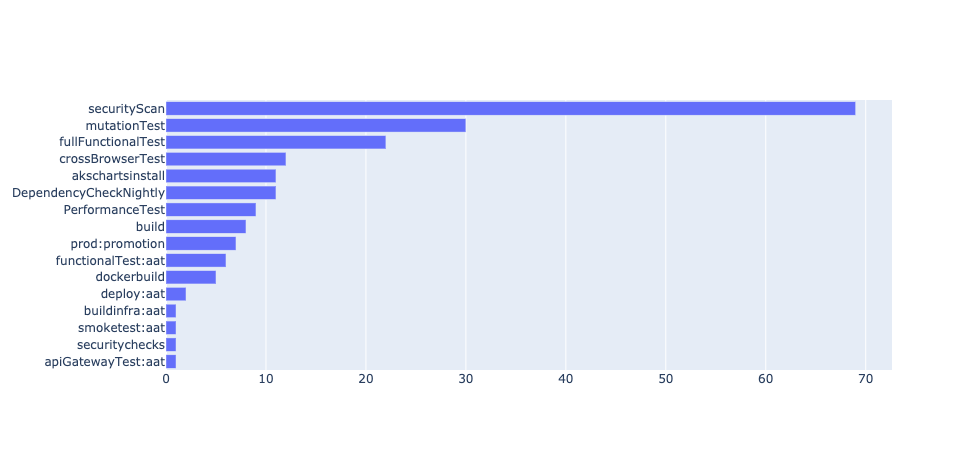

In [112]:
import plotly.graph_objects as go

labels = list(data.index[0:len(data.index)])
values = list(data.values)

fig = go.Figure(
    data=[go.Bar(y=labels, x=values, orientation='h')],
    layout=dict(yaxis=dict(autorange="reversed"))
    )
fig.show()